In [1]:
import jax
from jax import numpy as np
from jax import scipy as sp
from jax import random

from numpy.polynomial.hermite import hermgauss

import scipy.cluster.hierarchy as sch

import paragami

from copy import deepcopy

# regression-mixture libraries
from bnpreg_runjingdev import genomics_data_utils
from bnpreg_runjingdev import regression_mixture_lib
from bnpreg_runjingdev import regression_posterior_quantities as reg_posterior_quantities

import regression_plotting_utils

# BNP libraries
from bnpmodeling_runjingdev import result_loading_utils
from bnpmodeling_runjingdev import influence_lib
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib
from bnpmodeling_runjingdev.sensitivity_lib import get_cross_hess

import matplotlib.pyplot as plt
%matplotlib inline

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp

# Load data

In [3]:
# Set bnp_data_repo to be the location of a clone of the repo
# https://github.com/NelleV/genomic_time_series_bnp
bnp_data_repo = '../../../genomic_time_series_bnp' 

genome_data, timepoints, regressors, beta, beta_infos, y_infos = \
    genomics_data_utils.load_data_and_run_regressions(bnp_data_repo)
n_genes = genome_data.shape[0]
reg_dim = regressors.shape[1]

n_timepoints = len(np.unique(timepoints))

Loading data from:  ../../../genomic_time_series_bnp/data/shoemaker2015reprocessed


# Load fits

In [4]:
out_folder = '../fits/'
out_filename = 'mice_genomics_fit'
alpha0 = 6.0

In [5]:
vb_init_dict, vb_params_paragami, meta_data = \
    paragami.load_folded(out_folder + out_filename + '_alpha' + str(alpha0) + '.npz')

In [6]:
print(vb_params_paragami)

OrderedDict:
	[stick_params] = OrderedDict:
	[stick_means] = NumericArrayPattern (39,) (lb=-inf, ub=inf)
	[stick_infos] = NumericArrayPattern (39,) (lb=0.0001, ub=inf)
	[centroids] = NumericArrayPattern (40, 10) (lb=-inf, ub=inf)
	[data_info] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


In [7]:
vb_init_free = vb_params_paragami.flatten(vb_init_dict, free = True)

### Some meta data and model parameters

In [8]:
# gauss-hermite parameters
gh_deg = int(meta_data['gh_deg'])
gh_loc, gh_weights = hermgauss(gh_deg)

gh_loc = np.array(gh_loc)
gh_weights = np.array(gh_weights)
    
# load prior parameters
prior_params_dict, prior_params_paragami = regression_mixture_lib.get_default_prior_params()

# set initial alpha
assert alpha0 == meta_data['dp_prior_alpha']
prior_params_dict['dp_prior_alpha'] = alpha0

print(prior_params_dict)

{'dp_prior_alpha': 6.0, 'prior_centroid_mean': DeviceArray([0.], dtype=float64), 'prior_centroid_info': DeviceArray([0.1], dtype=float64), 'prior_shift_mean': DeviceArray([0.], dtype=float64), 'prior_shift_info': DeviceArray([0.1], dtype=float64), 'prior_data_info_shape': DeviceArray([1.], dtype=float64), 'prior_data_info_scale': DeviceArray([0.0001], dtype=float64)}


# Load influence results

In [9]:
influence_file = out_folder + out_filename + '_alpha' + str(alpha0) + '_influence.npz'

print(influence_file) 

influence_results = np.load(influence_file)

../fits/mice_genomics_fit_alpha6.0_influence.npz


In [10]:
# check that things in the influence file match things in my fit file
assert np.all(influence_results['vb_opt'] == vb_init_free)
assert np.all(influence_results['kl'] == meta_data['final_kl'])

# Define posterior quantity

In [11]:
# seed that was saved in computing the influence functions
prng_key = jax.random.PRNGKey(influence_results['seed'])

threshold = 0

@jax.jit
def get_n_clusters_insample(vb_free):
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return reg_posterior_quantities.get_e_num_clusters_from_vb_dict(genome_data, regressors,
                                                                        vb_params_dict,
                                                                        prior_params_dict,
                                                                        gh_loc, gh_weights,
                                                                        threshold = threshold,
                                                                        n_samples = 1000, 
                                                                        prng_key = prng_key)

@jax.jit
def get_n_clusters_pred(vb_free):
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return reg_posterior_quantities.get_e_num_pred_clusters_from_vb_dict(vb_params_dict,
                                                               n_obs = genome_data.shape[0],
                                                               threshold = threshold,
                                                               prng_key = prng_key)


# Plot influence function

In [12]:
logit_v_grid = influence_results['logit_v_grid']

In [13]:
# the prior (for plotting)
def p0(logit_v, alpha0): 
    return np.exp(influence_lib.get_log_logitstick_prior(logit_v, alpha0))

In [14]:
# function to get worst-case log-phi
def get_wc_log_phi_grid(influence_grid): 
    # returns log_phi at points logit_v_grid
    # just for plotting
    
    worst_case = influence_lib.WorstCasePerturbation(influence_fun = None, 
                                                    logit_v_grid = logit_v_grid, 
                                                    delta = 1.,
                                                    cached_influence_grid = influence_grid)

    return worst_case.log_phi(logit_v_grid), worst_case.change_points


In [15]:
def plot_influence_grid(influence_grid, influence_grid_x_prior, ax): 
    
    # plot y = 0 line
    for i in range(4): 
        ax[i].axhline(0, color = 'black')
    
    # plot influence function
    ax[0].plot(logit_v_grid, influence_grid, color = '#43a2ca')
    
    # plot prior
    ax[1].plot(logit_v_grid, p0(logit_v_grid, alpha0), 
                  color = '#7bccc4')
    
    # plot influence x prior
    ax[2].plot(logit_v_grid, influence_grid_x_prior, color = '#0868ac')
    
    # plot l-inf worst-case perturbation
    wc_log_phi, change_points = get_wc_log_phi_grid(influence_grid)
    ax[3].plot(logit_v_grid, wc_log_phi, color = 'grey')
    ax[3].fill_between(logit_v_grid, 0, wc_log_phi, color = 'grey', alpha = 0.5)
    
    for cp in change_points: 
        ax[2].axvline(cp, color = 'grey', linestyle = 'dashed')
    
    ax[0].set_ylabel('influence')
    ax[1].set_ylabel('prior')
    ax[2].set_ylabel('influence x prior')
    ax[3].set_ylabel('worst-case log phi')


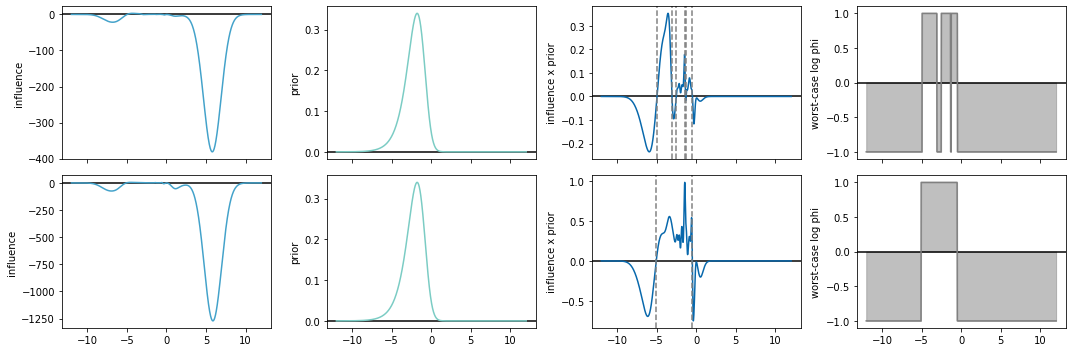

In [16]:
fig, axarr = plt.subplots(2, 4, figsize = (15, 5),  sharex = True) 

plot_influence_grid(influence_results['num_clust_infl'], 
                    influence_results['num_clust_infl_x_prior'],
                    axarr[0])

plot_influence_grid(influence_results['num_clust_pred_infl'], 
                    influence_results['num_clust_pred_infl_x_prior'],
                    axarr[1])


fig.tight_layout()

# Function to load refitted vb parameters

In [17]:
def load_refit_results(g, g_name): 
    match_crit = out_filename + '_' + g_name + '_wc_eps' + '\d+.npz'
    
    # load free parameters
    vb_refit_list, epsilon_vec, meta_data_list = \
        result_loading_utils.load_refit_files_epsilon(out_folder, match_crit)
    
    g_refit_list = np.array([g(x) for x in vb_refit_list])
    
    return g_refit_list, vb_refit_list, epsilon_vec

# Function to get LR results

In [18]:
def get_lr_results(g, g_name, epsilon_vec): 
    # get cross-hessian 
    cross_hess = influence_results[g_name + '_wc_cross_hess']
    
    # gradient of g times hessian 
    ghess = influence_results[g_name + '_ghess']
    
    # get derivative 
    dg_dhyper = np.dot(ghess, -cross_hess)
    
    # get lr results
    lr_g_array = g(vb_init_free) + dg_dhyper * epsilon_vec
    
    return lr_g_array


# Function to plot results

In [19]:
def plot_results(g, g_name): 
    
    fig, ax = plt.subplots(1, 4, figsize = (14, 3.5))
    
    # load refit and lr posterior statistic
    refit_g_vec, vb_refit_list, epsilon_vec = load_refit_results(g, g_name)
    lr_g_vec = get_lr_results(g, g_name, epsilon_vec)
    
    # define worst-case log phi
    worst_case = influence_lib.WorstCasePerturbation(influence_fun = None, 
                                                    logit_v_grid = logit_v_grid, 
                                                    delta = 1.,
                                                    cached_influence_grid = influence_results[g_name + '_infl'])
    
    ###################
    # plot prior x influence function 
    ###################
    influence_x_prior_grid = influence_results[g_name + '_infl_x_prior']
    ax[0].plot(logit_v_grid, influence_x_prior_grid)
    
    # plot y = 0
    ax[0].axhline(0, color = 'black')

    # overlay bump
    ax[0].plot(logit_v_grid, 
               worst_case.log_phi(logit_v_grid),
               color = 'grey')

    ax[0].fill_between(logit_v_grid, 
                       0,
                       worst_case.log_phi(logit_v_grid),
                       color = 'grey',
                       alpha = 0.5)
    ax[0].set_ylim((influence_x_prior_grid.min() * 0.95, 
                     influence_x_prior_grid.max() * 1.05))
    ax[0].set_xlabel('influence x prior')

    ###################
    # plot perturbed prior 
    ###################
    # compute perturbed prior
    prior_perturbation = func_sens_lib.PriorPerturbation(
                                alpha0 = alpha0,
                                log_phi = worst_case.log_phi, 
                                logit_v_ub = 10, 
                                logit_v_lb = -10)

    prior_perturbation._plot_priors(ax[1])
    prior_perturbation._plot_priors_constrained(ax[2])
    ax[2].legend()

    for j in range(3): 
        ax[j].set_xlabel('logit-sticks')

    ###################
    # plot posterior statistic 
    ###################                        
    # plot refit results
    ax[3].plot(epsilon_vec,
                  refit_g_vec - refit_g_vec[0], 
                  '-o', 
                  label = 'refit')

    # plot lr results
    ax[3].plot(epsilon_vec, 
                  lr_g_vec - lr_g_vec[0], 
                  '-o', 
                  label = 'lr')

    ax[3].set_xlabel('epsilon')
    ax[3].axhline(0, color = 'black')

    ax[3].legend()
    ax[3].set_ylabel('g(pert) - g(init)')

    fig.tight_layout()


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.815214e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 4.694184e-01
  warnings.warn(


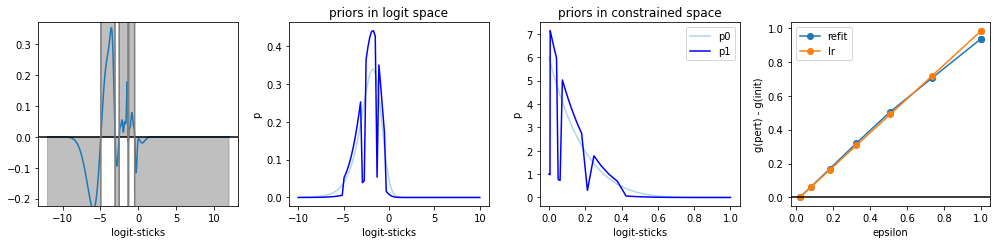

In [20]:
worst_case = plot_results(get_n_clusters_insample, 'num_clust')

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.788776e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 7.596086e-02
  warnings.warn(


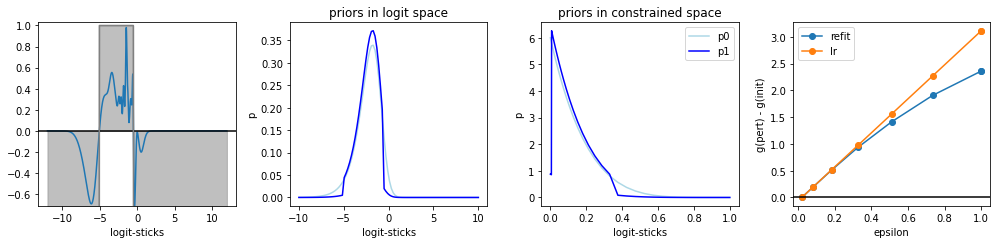

In [21]:
worst_case = plot_results(get_n_clusters_pred, 'num_clust_pred')